<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/moded_spectrum_analysis_v8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrum Analysis V2

# Loading Necesary Libraries

In [79]:
# Importing necesary libraries
# Libraries for correct code execution 

import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
import random
import csv
import re
import array
import seaborn as sns
from tqdm import tqdm

from random import random, gauss
from math import modf, pi, cos, sin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
from scipy.signal import savgol_filter
from scipy.stats.stats import pearsonr
from scipy.stats import spearmanr

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

from keras.models import Sequential
from keras.layers import Dense,Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.mixture import GaussianMixture

import warnings
warnings.filterwarnings("ignore")

sns.set_theme()

# Load Enviroment

In [80]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [81]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

# Load Datasets

In [82]:
input_path = path + "/Spectrum/16QAM/25spans80km_withoutROADMs/dataSet_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x80km.xlsx"

## Pre-Processing

In [83]:
df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)

In [84]:
# Dropping rows that are empty
drop_rows = [drop_row for drop_row in range(325, df.shape[0])]
df_13_samples = df.drop(drop_rows)

In [85]:
# Adding missing PBRS_id
snippet = []
val_cnt = 1
idx = 0
for sample in range(1, 14):
  for sample_id in range(0, 25):
    df_13_samples.at[idx, 'PBRS_id'] = val_cnt
    idx +=1
    snippet.append(val_cnt)
  val_cnt += 1
df_13_samples['PBRS_id'] = df_13_samples['PBRS_id'].astype(int)

In [86]:
df_13_samples.iloc[0].fillna(method='bfill', inplace=True)

df_13_samples.iloc[1:df_13_samples.shape[0]].fillna(method='pad', inplace=True)

# Cut Tails with on wanted data

## Calculate the average value of groups

In [87]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
      break
    i+=1
  return prime_nums

def aggreagator_v2(df, stop_gap=50):
  total_num_of_data = df.shape[1]
  arr_prime = prime_number_finder(stop_gap, total_num_of_data)
  #agg_num = np.max(arr_prime)
  agg_num = arr_prime[0]

  # Creating new df of aggregate values
  agg_df = pd.DataFrame()

  mid_point = df.shape[1]/2

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)

    headers = list(new_df.columns.values) 
    if loop_cnt <= mid_point:
      # Get average of freq values for new header
      new_header_name  = headers[-1]
    else:
      new_header_name = headers[0]
    
    # Add aggragated values to new df
    agg_df[new_header_name] = new_df.mean(axis = 1)
  return agg_df

## Select the first sample for testing of the mean values

## Find cut off index

In [88]:
def remove_tail(df, cut_val, sample_id):
  columns_selected = []
  old_val = 0
  delta = 0
  mid_point = int(df.shape[1]/2)
  cols_headers  = list(df.columns.values)

  for i in range(0, df.shape[1]):
    if i == 0:
      cell_val = df.iloc[[0], i]
      old_val = cell_val[sample_id]
    else:
      cell_val = df.iloc[[0], i]
      val = cell_val[sample_id]
      delta = abs(old_val-val)
      old_val = val
      if delta > cut_val:
        if i <= mid_point:
          col_name_selected = cols_headers[i+2]
        else:
          col_name_selected = cols_headers[i-2]
          col_name_selected = round(float(col_name_selected), 5)
        columns_selected.append(col_name_selected)

  return columns_selected

In [89]:
# Removing tails conducting multiples loops with variable cutoff value until we get only two columns
def remove_tail_main(df, cut_val, sample_id):
  old_drop_cols = []
  drop_cols = remove_tail(df, cut_val, sample_id)
  while len(drop_cols) != 2:  
    # If len of columns to be dropped are 0 the select the 2 values smaller and bigger of the previous iteration
    if len(drop_cols) == 0 or len(drop_cols) == 1:
      drop_cols = [np.min(old_drop_cols), np.max(old_drop_cols)]
      break
    else:
      old_drop_cols = drop_cols
      drop_cols = remove_tail(df, cut_val, sample_id)
      cut_val += 2
  return drop_cols

In [90]:
def get_working_data_idx_v2(df_mean_sample, sample_id, cut_val = 0):

  df = df_mean_sample.iloc[[sample_id - 1]]

  agg_df = aggreagator_v2(df)

  col_vals = remove_tail_main(agg_df, cut_val=cut_val, sample_id=sample_id)

  left_index_no = df.columns.get_loc(col_vals[0])
  rigth_index_no = df.columns.get_loc(col_vals[1])

  return left_index_no, rigth_index_no

In [91]:
def cur_off_idx(df): # return tuple with cut-off values (index_left_side, index_rigth_side)
  df_mean_sample = df.groupby(['PBRS_id']).mean()
  df_mean_sample = df_mean_sample.drop(['row', 'Channels', 'Distance_km', 'power_dBm'], axis = 1)

  cut_points = {}
  print('Calculating the cutoff values:')
  for sample in tqdm(df_mean_sample.index):
    left_index_no, rigth_index_no = get_working_data_idx_v2(df_mean_sample, sample_id = sample)
    cut_points[sample] = (left_index_no, rigth_index_no)

  left_cut_off = np.max([v[0] for k, v in cut_points.items()])
  rigth_cut_off = np.min([v[1] for k, v in cut_points.items()])

  cut_point = (left_cut_off, rigth_cut_off)
  return cut_point

In [92]:
cut_point = cur_off_idx(df_13_samples)

Calculating the cutoff values:


100%|██████████| 13/13 [00:08<00:00,  1.56it/s]


In [93]:
cut_point

(251, 2318)

## Select working data

In [94]:
def select_working_data(df, cut_point): # implement cut_off values and Smoothing original df after cutt-of
  extra_info_df = df.iloc[:, 0:6]
  data_df = df.iloc[:, cut_point[0]+6:cut_point[1]+6]
  smoothed_data_frame = pd.DataFrame(savgol_filter(data_df, window_length = 5, polyorder = 2))
  
  # Adding back headers to the smoothed data
  rename_col = {}
  cnt = 0
  for col in data_df.columns:
    h_col = round(float(col), 5)
    rename_col[cnt] = h_col
    cnt += 1
  smoothed_data_frame.rename(columns=rename_col, inplace=True)

  working_df = pd.merge(extra_info_df, smoothed_data_frame, left_index=True, right_index=True)
  return working_df

In [95]:
working_df = select_working_data(df_13_samples, cut_point)
working_df

,row,PBRS_id,Channels,Distance_km,power_dBm,#span,-32.15625,-32.125,-32.09375,-32.0625,...,32.125,32.15625,32.1875,32.21875,32.25,32.28125,32.3125,32.34375,32.375,32.40625
0,1,1,1,80.0,0,1,-14.851402,-21.638525,-23.529105,-14.969324,...,-19.957216,-19.447732,-14.576655,-15.491358,-14.654316,-17.801658,-16.387551,-13.980891,-15.122689,-17.753853
1,2,1,1,160.0,0,2,-32.415520,-23.442737,-17.642596,-16.382163,...,-15.348137,-13.125596,-15.424900,-18.560355,-17.197693,-12.466164,-12.735882,-10.007690,-13.820587,-21.908636
2,3,1,1,240.0,0,3,-23.428437,-21.738735,-19.956032,-18.320372,...,-21.210045,-20.014100,-13.636612,-9.728106,-7.977970,-19.904029,-22.658427,-19.765777,-24.603827,-31.921519
3,4,1,1,320.0,0,4,-14.298403,-15.210905,-15.951684,-16.209202,...,-18.673789,-12.470911,-12.638057,-9.282286,-12.488977,-10.933173,-15.749634,-15.676254,-15.412170,-14.347517
4,5,1,1,400.0,0,5,-19.455200,-19.755724,-18.313774,-13.272877,...,-17.697814,-16.074418,-16.232349,-13.788018,-22.471867,-23.016590,-22.392253,-18.544159,-18.765642,-23.196090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,321,13,1,1680.0,0,21,-31.466739,-32.655263,-31.882492,-27.589879,...,-34.359245,-32.466935,-29.543434,-31.321699,-33.322457,-34.343455,-30.096108,-33.185712,-33.367392,-33.876192
321,322,13,1,1760.0,0,22,-21.303913,-33.080588,-37.034437,-31.766035,...,-32.977742,-28.624796,-27.495186,-23.847968,-25.561252,-34.242901,-40.735728,-34.014182,-33.957388,-35.627786
322,323,13,1,1840.0,0,23,-27.601906,-27.758137,-27.102083,-27.319948,...,-33.646975,-25.620092,-34.883694,-42.119980,-35.870338,-28.109018,-32.237494,-32.837088,-31.096978,-25.976283
323,324,13,1,1920.0,0,24,-31.725625,-38.937830,-39.113483,-26.640446,...,-21.790284,-24.651905,-26.129703,-26.548903,-25.567147,-30.324506,-30.829273,-33.027456,-34.010274,-34.402337


In [96]:
'''
test_df = df_mean_sample.iloc[[0]]
sample_1 = test_df.iloc[0].squeeze()
sample_1.plot()
plt.show()
'''

'\ntest_df = df_mean_sample.iloc[[0]]\nsample_1 = test_df.iloc[0].squeeze()\nsample_1.plot()\nplt.show()\n'

In [97]:
'''
smoothed_2dg = savgol_filter(test_df, window_length = 5, polyorder = 2)
gfg = pd.Series(smoothed_2dg[0])
gfg.plot()
plt.show()
'''

'\nsmoothed_2dg = savgol_filter(test_df, window_length = 5, polyorder = 2)\ngfg = pd.Series(smoothed_2dg[0])\ngfg.plot()\nplt.show()\n'

# Pearson Correlation

In [98]:
#eval_method = 'avg' or 'min' or 'max'

def pearson_matrix(working_df , source_sample_id, eval_method = 'avg'):
  distances = [x*80 for x in range(1, 26)]
  result_data = {'source/target': distances}
  
  print('Generating Pearson Confusion Matrix using ({}) method:'.format(eval_method))
  for target_dist in tqdm(distances): # loop all distances available
    result_target = []
    for source_dist in distances: # loop all distances available
      source_df = working_df[(working_df['Distance_km'] == source_dist) & (working_df['PBRS_id'] == source_sample_id)]# select data of source (distance and sample_id) 
      source_data = source_df.iloc[0, 6:source_df.shape[1]].tolist()
      pearson_values = []
      for target_sample_id in working_df['PBRS_id'].unique(): # loop all samples id to then exclude the source sample id
        if target_sample_id != source_sample_id:
          target_df = working_df[(working_df['Distance_km'] == target_dist) & (working_df['PBRS_id'] == target_sample_id)] # select data of target
          target_data = target_df.iloc[0, 6:target_df.shape[1]].tolist()
          pearson_values.append(round(pearsonr(source_data, target_data)[0], 5)) # pearson correlation
      if eval_method == 'avg':
        p_result = np.mean(pearson_values)
      elif eval_method == 'max':
        p_result = np.max(pearson_values)
      elif eval_method == 'min':
        p_result = np.min(pearson_values)
      result_target.append(p_result)
    result_data[target_dist] = result_target

  pearson_matrix_df = pd.DataFrame.from_dict(result_data)
  #pearson_matrix_df = pearson_matrix_df.set_index('source/target')

  return pearson_matrix_df, result_data

In [99]:
'''
avg_p_matrix, avg_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'avg')
min_p_matrix, min_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'min')
max_p_matrix, max_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'max')
'''

"\navg_p_matrix, avg_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'avg')\nmin_p_matrix, min_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'min')\nmax_p_matrix, max_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'max')\n"

In [100]:
'''
avg_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_AVG.csv'
avg_p_matrix.to_csv(avg_p_matrix_output_path, index=False)  

min_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MIN.csv'
min_p_matrix.to_csv(min_p_matrix_output_path, index=False)  

max_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MAX.csv'
max_p_matrix.to_csv(max_p_matrix_output_path, index=False)
'''

"\navg_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_AVG.csv'\navg_p_matrix.to_csv(avg_p_matrix_output_path, index=False)  \n\nmin_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MIN.csv'\nmin_p_matrix.to_csv(min_p_matrix_output_path, index=False)  \n\nmax_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MAX.csv'\nmax_p_matrix.to_csv(max_p_matrix_output_path, index=False)\n"

In [101]:
avg_p_matrix, avg_result_data = pearson_matrix(working_df , source_sample_id=1, eval_method = 'max')

Generating Pearson Confusion Matrix using (max) method:


100%|██████████| 25/25 [00:18<00:00,  1.39it/s]


## Pickle out the dictionary of correlations

In [102]:
def pickle_out(dump_file, filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  pickleout = open(filepath, "wb")
  pickle.dump(dump_file, pickleout)
  pickleout.close()

In [103]:
'''
pickle_out(avg_result_data, 'avg_correlation_matrix')
pickle_out(min_result_data, 'min_correlation_matrix')
pickle_out(max_result_data, 'max_correlation_matrix')
'''

"\npickle_out(avg_result_data, 'avg_correlation_matrix')\npickle_out(min_result_data, 'min_correlation_matrix')\npickle_out(max_result_data, 'max_correlation_matrix')\n"

# Individual point selection analysis

In [104]:
def calc_freq_behavior(working_df, selected_point, multi=False): # Individual freq calculator
  extra_data = working_df.iloc[:, 0:6]
  freq_selected = working_df.iloc[:, selected_point+6]

  freq_data_df = pd.merge(extra_data, freq_selected, left_index=True, right_index=True)
  freq_data_df['Distance_km'] = freq_data_df['Distance_km'].astype(int)

  headers = list(freq_data_df.columns.values)
  selected_val = round(float(headers[-1]), 5)

  distances = [x*80 for x in range(1, 26)]
  freq_behavior = {}
  f_behavior = {}
  if multi == False:
    for dist in tqdm(distances): # loop all distances available

      distance_df = freq_data_df[(freq_data_df['Distance_km'] == dist)] # select all the row with current eval distance
      freq_distance_vals = distance_df[selected_val].tolist()

      freq_mean = np.mean(freq_distance_vals)
      freq_std = np.std(freq_distance_vals)
      results = (freq_mean, freq_std)
      f_behavior[dist] = results
  else:
    for dist in distances: # loop all distances available

      distance_df = freq_data_df[(freq_data_df['Distance_km'] == dist)] # select all the row with current eval distance
      freq_distance_vals = distance_df[selected_val].tolist()

      freq_mean = np.mean(freq_distance_vals)
      freq_std = np.std(freq_distance_vals)
      results = (freq_mean, freq_std)
      f_behavior[dist] = results
  freq_behavior[selected_val] = f_behavior
  return freq_behavior

In [105]:
freq_behavior = calc_freq_behavior(working_df, selected_point=1)

100%|██████████| 25/25 [00:00<00:00, 1694.18it/s]


In [106]:
print(freq_behavior)

{-32.125: {80: (-25.40337564805794, 4.481808298335262), 160: (-24.010850390233657, 5.039803368532095), 240: (-21.340447696910022, 7.0997527464333094), 320: (-22.460661848901946, 5.390652128147111), 400: (-23.279367915416742, 5.823657640564345), 480: (-26.152543099025017, 5.654196781563158), 560: (-24.55708276808726, 5.9021665072880705), 640: (-21.16715209970093, 5.541860630158492), 720: (-23.075378599679116, 5.655136239793894), 800: (-23.525512864050945, 4.640255478332653), 880: (-25.739898467470823, 4.940621242299542), 960: (-23.73500884298251, 5.033610140183088), 1040: (-21.269319523944638, 5.932283279427541), 1120: (-23.220655184114168, 6.478158707515113), 1200: (-23.312980550744236, 4.854096511848365), 1280: (-26.34103787520003, 5.418507799074288), 1360: (-25.192315244791992, 6.056445842478997), 1440: (-20.813537562626703, 6.4495022513520475), 1520: (-23.75256581820979, 6.266288872309622), 1600: (-23.81425496644484, 5.655397778095744), 1680: (-26.220037370633957, 5.956321897789714)

In [107]:
def rand(start, end, num): # get random value function
    res = []
    for j in range(num):
        res.append(np.random.randint(start, end))
    return res

In [108]:
def multiple_freq_analyzer(working_df, number_freq_to_analyze, method): #method = 'rand' or 'even' (multiple freq behavior calculator)
  if method == 'even': 
    break_point = int((working_df.shape[1]-6)/(number_freq_to_analyze+1))
    selected_cols = []
    for col_idx in range(1, number_freq_to_analyze+1):
      selected_cols.append((col_idx*break_point)-1)
  else:
    selected_cols = rand(1, working_df.shape[1]-6, number_freq_to_analyze)
    selected_cols = sorted(selected_cols)
  multi_freq_behavior = {}
  for selected_point in tqdm(selected_cols):
    freq_behavior = calc_freq_behavior(working_df, selected_point, multi=True)
    selected_v = [v for v in freq_behavior.keys()]

    selected_d = {}
    for data in freq_behavior.values():
      for k, v in data.items():
        selected_d[k] = v

    multi_freq_behavior[selected_v[0]] = selected_d
  return multi_freq_behavior

In [109]:
multi_freq_behavior = multiple_freq_analyzer(working_df, number_freq_to_analyze=3, method='even')

100%|██████████| 3/3 [00:00<00:00, 55.44it/s]


In [110]:
print(multi_freq_behavior.keys())
print(multi_freq_behavior)

dict_keys([-16.0625, 0.0625, 16.1875])
{-16.0625: {80: (-10.90560527414711, 2.5764097121587533), 160: (-11.37540738697896, 5.437228520568107), 240: (-9.073913619304726, 1.5405800001225076), 320: (-10.34287587783075, 2.140421520550517), 400: (-11.081527653866704, 2.523000410783392), 480: (-10.489384011651378, 2.3797947917572717), 560: (-11.594235376371977, 5.4069423961777545), 640: (-8.92459883658142, 1.4403297876869152), 720: (-10.42782355969006, 2.0179287037745564), 800: (-10.801137840431775, 2.3457091843548867), 880: (-10.471011491362587, 2.4407158197600833), 960: (-11.471875902063884, 5.395736660237377), 1040: (-8.862562497053935, 1.4039969664116494), 1120: (-10.802711860093122, 2.3005671035094144), 1200: (-10.84654004896751, 2.4514631418002253), 1280: (-10.472806618537609, 2.3484559622764207), 1360: (-11.772283098064346, 5.388148544694113), 1440: (-8.839241679757842, 1.5070659947643457), 1520: (-10.308798536224185, 2.0741857432903585), 1600: (-10.800985154599065, 2.3372969632949836

In [111]:
def freq_dict_to_df(multi_freq_behavior):
  distances = [x*80 for x in range(1, 26)]
  freq_mean_data = {'distances':distances}
  freq_std_data = {'distances':distances}

  for header, distances_dict in multi_freq_behavior.items():
    col_data_mean = []
    col_data_std = []
    for distance, results in distances_dict.items():
      col_data_mean.append(results[0])
      col_data_std.append(results[1])
    freq_mean_data[header] = col_data_mean
    freq_std_data[header] = col_data_std

  freq_mean_df = pd.DataFrame(freq_mean_data)
  freq_std_df = pd.DataFrame(freq_std_data)
  
  return freq_mean_df, freq_std_df

In [112]:
freq_mean_df, freq_std_df = freq_dict_to_df(multi_freq_behavior)

## Plots

In [113]:
def plot_freq_mean(freq_behavior):
  x = []
  y = []
  for selected_val, values in freq_behavior.items():
    for dist, mean_std in values.items():
      x.append(dist)
      y.append(mean_std[0])
    fig = plt.figure()
    plt.title("Mean of Frequency {} behavior through distances".format(selected_val))
    plt.xlabel("Distances")
    plt.ylabel("Power")  

    plt.plot(x, y)
    #plt.savefig(path+/'mean_frequency_{}_behavior.png'.format(selected_val))
    plt.show()

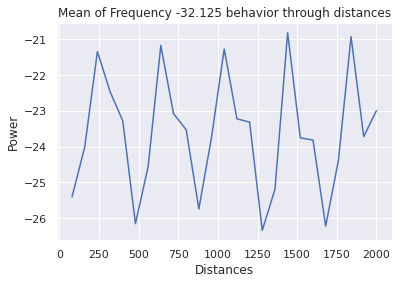

In [114]:
plot_freq_mean(freq_behavior)

In [115]:
def plot_freq_mean_std(freq_behavior, method, save=True):
  x = []
  y = []
  y_upper = []
  y_lower = []

  distances = []
  for selected_val, values in freq_behavior.items():
    for dist, mean_std in values.items():
      x.append(dist)
      y.append(mean_std[0])
      y_upper.append(mean_std[0] - mean_std[1])
      y_lower.append(mean_std[0] + mean_std[1])

    fig = plt.figure()
    
    plt.figure(figsize=(15, 4))
    plt.fill_between(x, y_upper, y_lower, alpha=.5, linewidth=0)
    plt.plot(x, y, linewidth=2)
    plt.xlim(np.min(x), np.max(x))
    plt.xticks(x)

    plt.title("Mean/Std of Frequency {} behavior through distances".format(selected_val))
    plt.xlabel("Distances")
    plt.ylabel("Power")  
  if save == True:
    plt.savefig(path+'/Spectrum/freq_behavior/mean_std/mean_std__behavior_for_frequency_{}_{}.png'.format(selected_val, method))
  plt.show()


<Figure size 432x288 with 0 Axes>

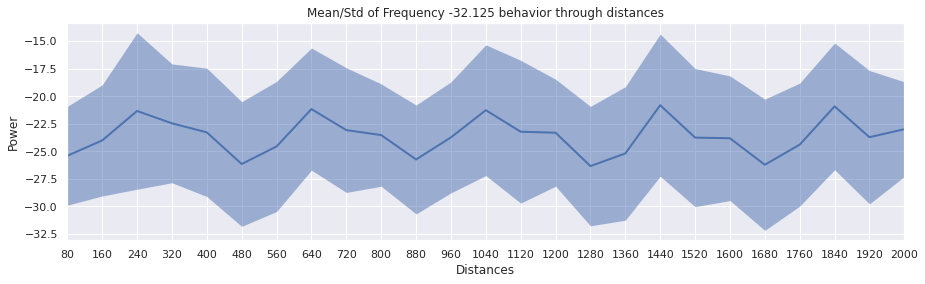

In [116]:
plot_freq_mean_std(freq_behavior, method='rand', save=False)

In [117]:
def plot_freq_behavior(working_df, freq_behavior, method, save=True):
  
  for selected_val, values in freq_behavior.items():

    extra_data = working_df.iloc[:, 0:6]
    freq_selected = working_df.loc[:, selected_val]

    freq_data_df = pd.merge(extra_data, freq_selected, left_index=True, right_index=True)
    freq_data_df['Distance_km'] = freq_data_df['Distance_km'].astype(int)

    distances = [x*80 for x in range(1, 26)]

    combined_freq = {}
    for d in distances:
      combined_freq[d] = []

    for sample_id in freq_data_df['PBRS_id'].unique(): # loop all samples id to then exclude the source sample id

      samples_df = freq_data_df[(freq_data_df['PBRS_id'] == sample_id)] # select data beloging at the same sample
      freq_distance_vals = samples_df[selected_val].tolist()

      for dist in samples_df['Distance_km'].unique():
        dist_samples_df = samples_df[(freq_data_df['Distance_km'] == dist)] # select data beloging at the same sample
        freq_distance_vals = dist_samples_df[selected_val].tolist()

        combined_freq[dist].append(freq_distance_vals[0])

    combined_list = combined_freq.items()
    combined_list = sorted(combined_list) 
    x, y = zip(*combined_list) 
    
    fig = plt.figure()
    plt.figure(figsize=(15, 4))
    for xe, ye in zip(x, y):
      plt.scatter([xe] * len(ye), ye)
    
    plt.xlim(np.min(distances)-25, np.max(distances)+25)
    plt.xticks(distances)

    plt.title("Frequency {} behavior through distances".format(selected_val))
    plt.xlabel("Distances")
    plt.ylabel("Power")
    if save == True:
      plt.savefig(path+'/Spectrum/freq_behavior/freq_distribution/behavior_for_frequency_{}_{}.png'.format(selected_val, method))
    plt.show()

<Figure size 432x288 with 0 Axes>

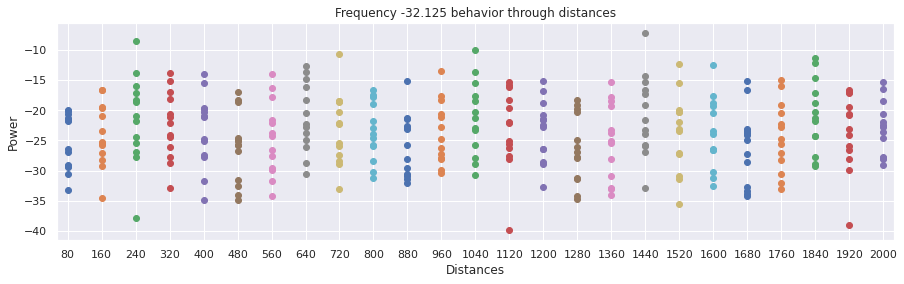

In [118]:
plot_freq_behavior(working_df, freq_behavior, method='rand', save=False)

## Run for specifict point

100%|██████████| 15/15 [00:00<00:00, 74.15it/s]


------------------


  0%|          | 0/15 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

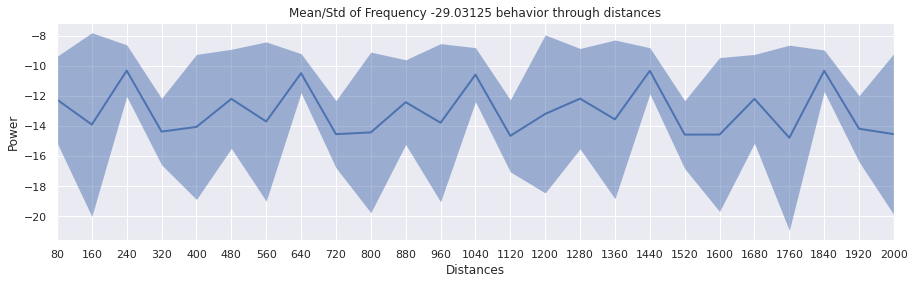

<Figure size 432x288 with 0 Axes>

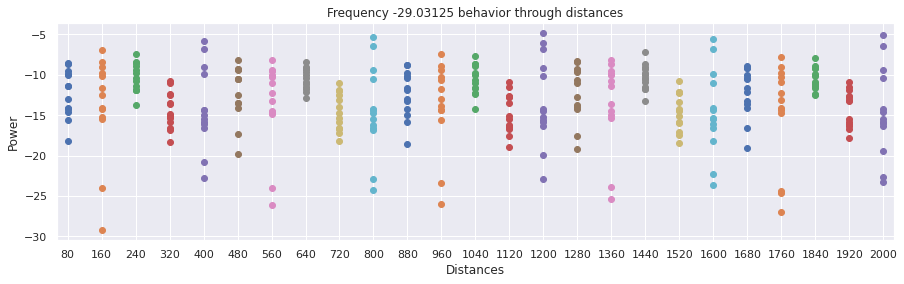

  7%|▋         | 1/15 [00:00<00:12,  1.11it/s]

------------------


<Figure size 432x288 with 0 Axes>

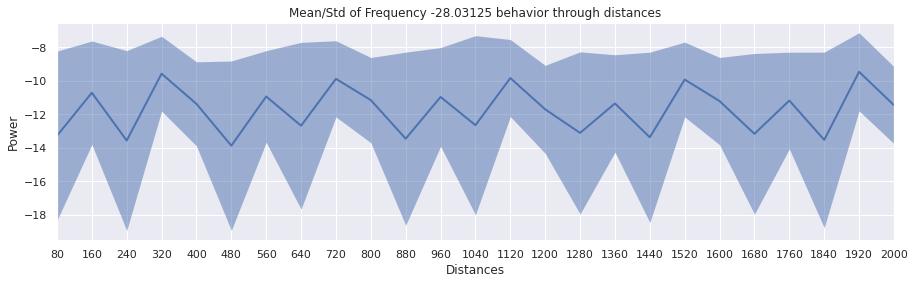

<Figure size 432x288 with 0 Axes>

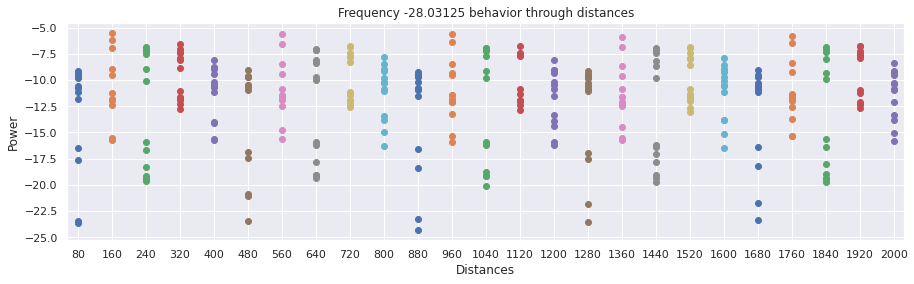

 13%|█▎        | 2/15 [00:01<00:11,  1.10it/s]

------------------


<Figure size 432x288 with 0 Axes>

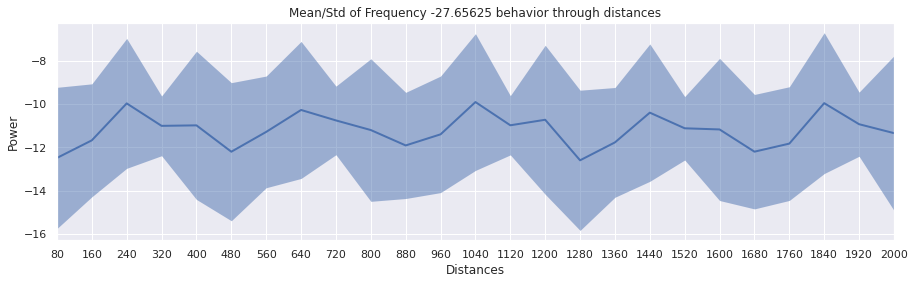

<Figure size 432x288 with 0 Axes>

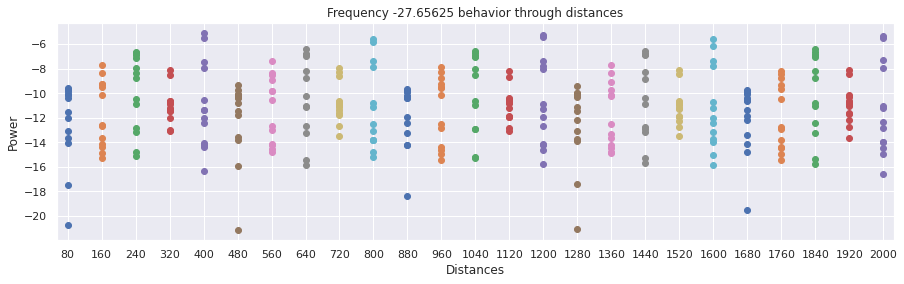

 20%|██        | 3/15 [00:02<00:11,  1.09it/s]

------------------


<Figure size 432x288 with 0 Axes>

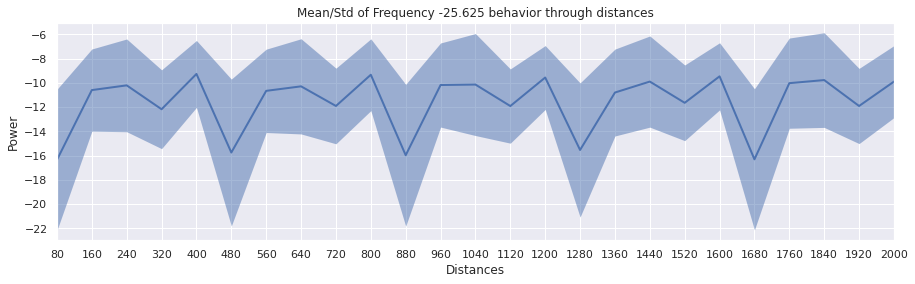

<Figure size 432x288 with 0 Axes>

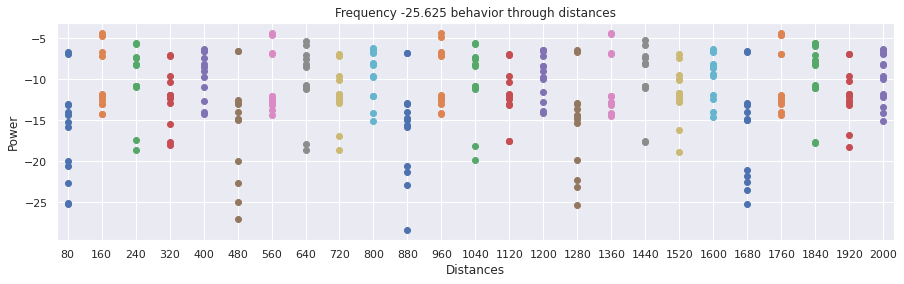

 27%|██▋       | 4/15 [00:03<00:10,  1.07it/s]

------------------


<Figure size 432x288 with 0 Axes>

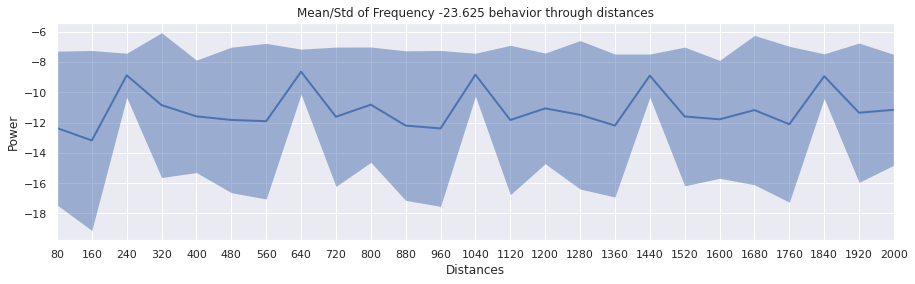

<Figure size 432x288 with 0 Axes>

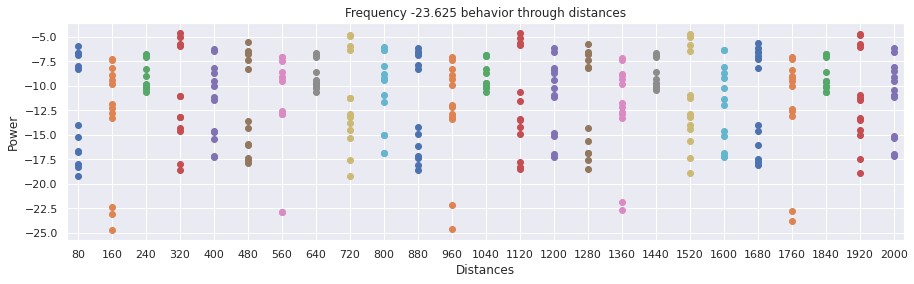

 33%|███▎      | 5/15 [00:04<00:09,  1.08it/s]

------------------


<Figure size 432x288 with 0 Axes>

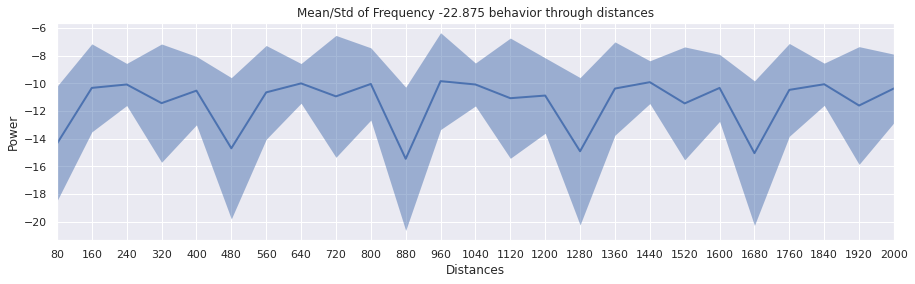

<Figure size 432x288 with 0 Axes>

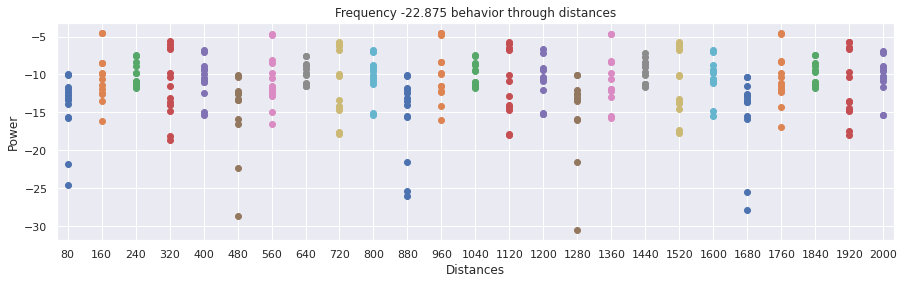

 40%|████      | 6/15 [00:05<00:08,  1.06it/s]

------------------


<Figure size 432x288 with 0 Axes>

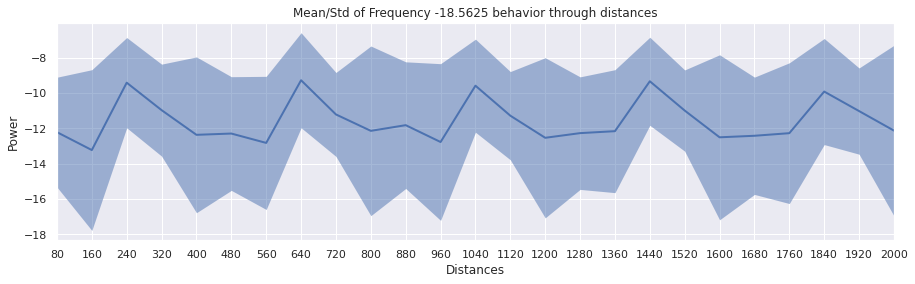

<Figure size 432x288 with 0 Axes>

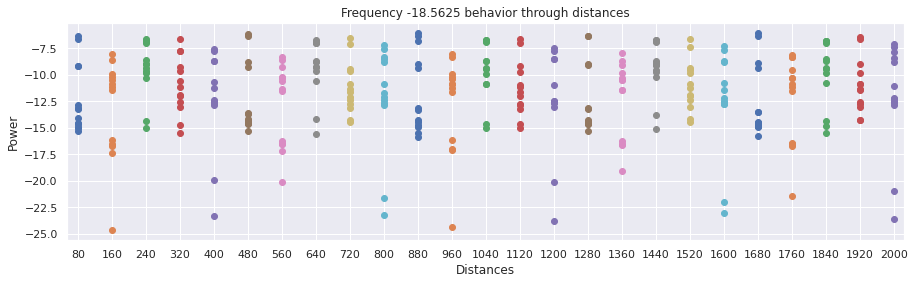

 47%|████▋     | 7/15 [00:06<00:07,  1.06it/s]

------------------


<Figure size 432x288 with 0 Axes>

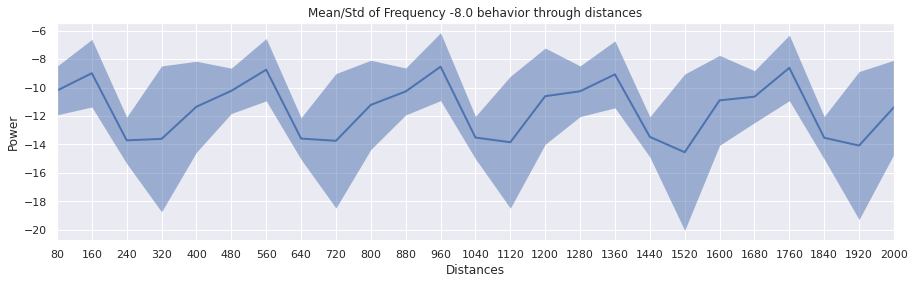

<Figure size 432x288 with 0 Axes>

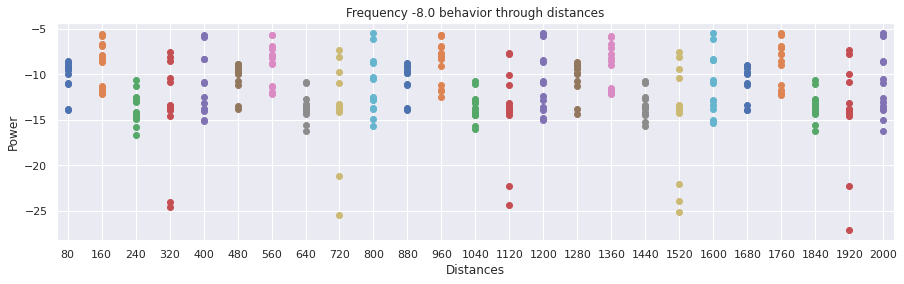

 53%|█████▎    | 8/15 [00:07<00:07,  1.00s/it]

------------------


<Figure size 432x288 with 0 Axes>

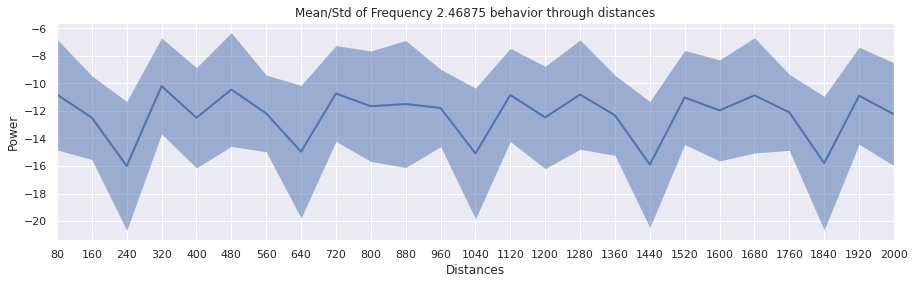

<Figure size 432x288 with 0 Axes>

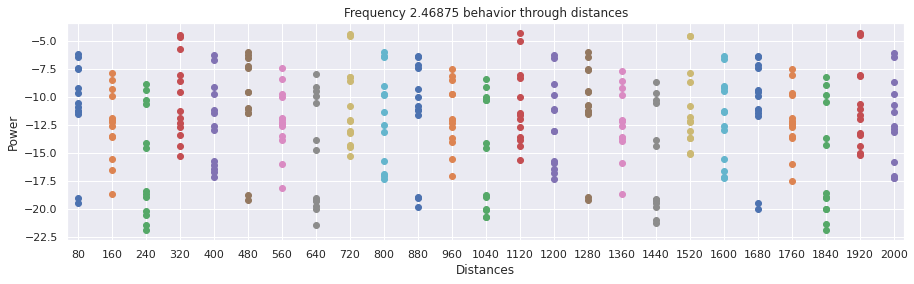

 60%|██████    | 9/15 [00:08<00:05,  1.01it/s]

------------------


<Figure size 432x288 with 0 Axes>

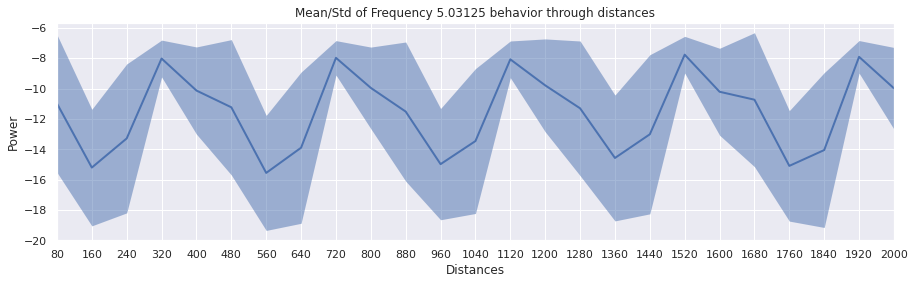

<Figure size 432x288 with 0 Axes>

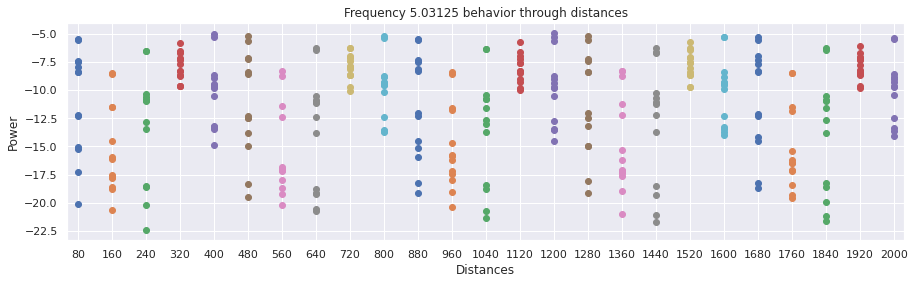

 67%|██████▋   | 10/15 [00:09<00:04,  1.04it/s]

------------------


<Figure size 432x288 with 0 Axes>

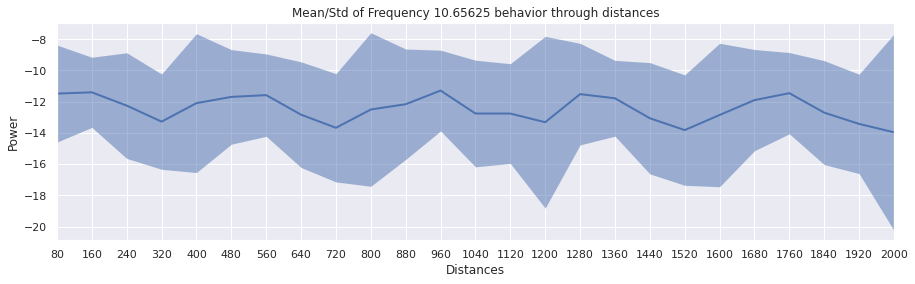

<Figure size 432x288 with 0 Axes>

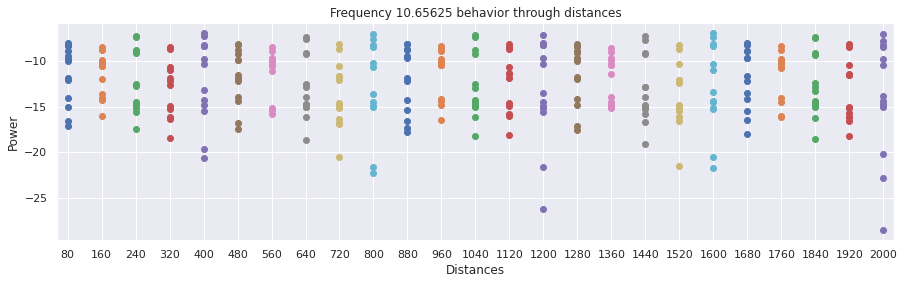

 73%|███████▎  | 11/15 [00:10<00:03,  1.02it/s]

------------------


<Figure size 432x288 with 0 Axes>

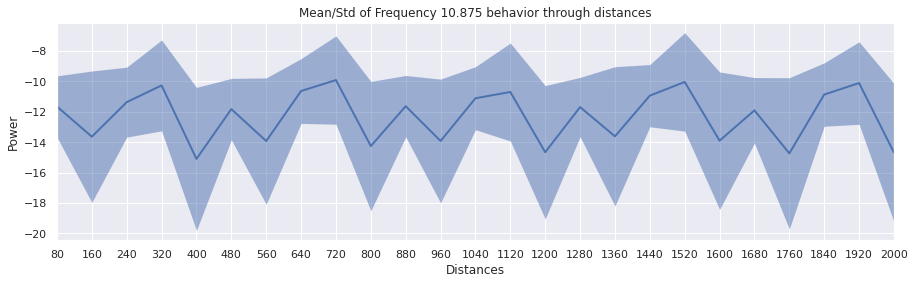

<Figure size 432x288 with 0 Axes>

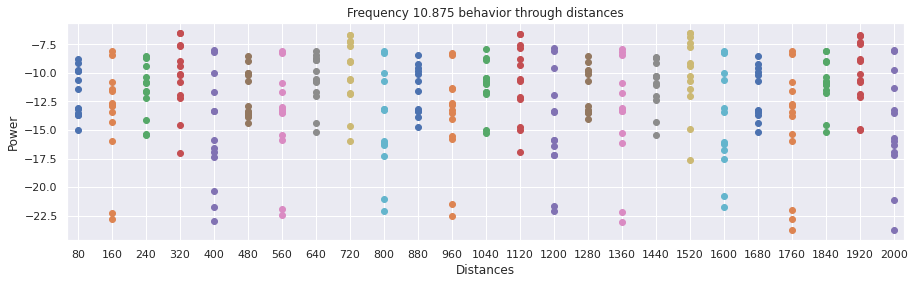

 80%|████████  | 12/15 [00:11<00:03,  1.12s/it]

------------------


<Figure size 432x288 with 0 Axes>

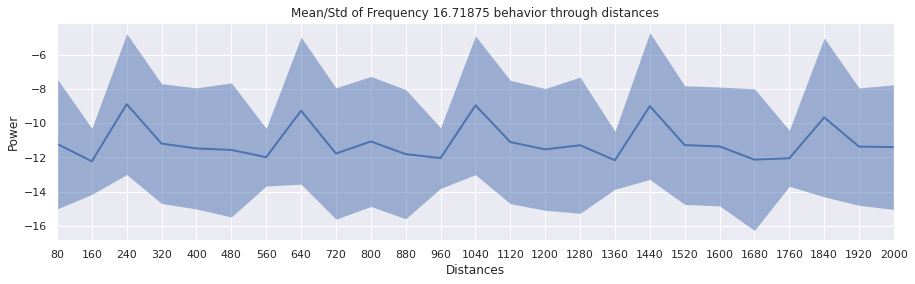

<Figure size 432x288 with 0 Axes>

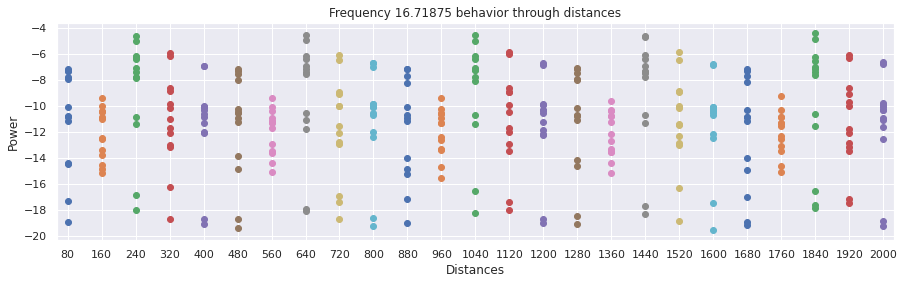

 87%|████████▋ | 13/15 [00:13<00:02,  1.17s/it]

------------------


<Figure size 432x288 with 0 Axes>

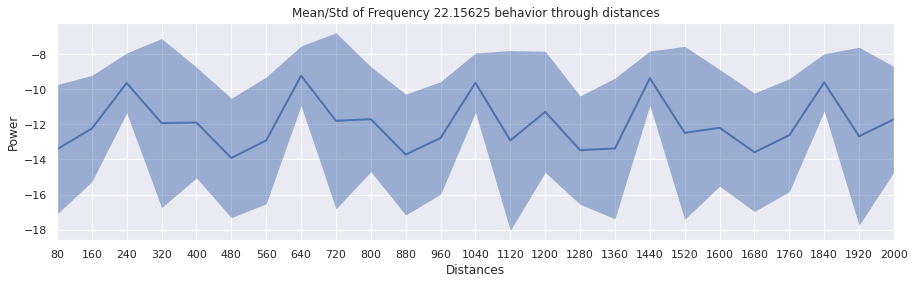

<Figure size 432x288 with 0 Axes>

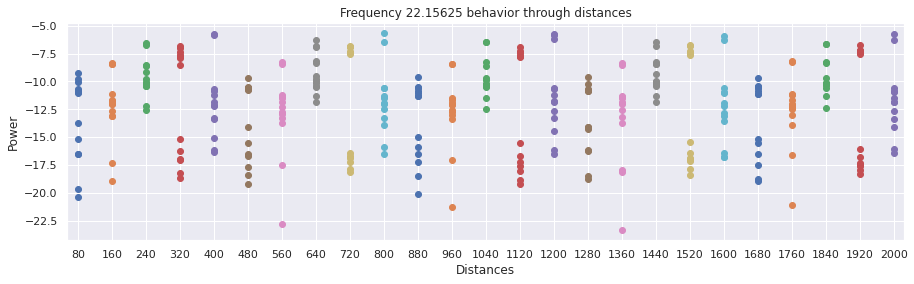

 93%|█████████▎| 14/15 [00:14<00:01,  1.17s/it]

------------------


<Figure size 432x288 with 0 Axes>

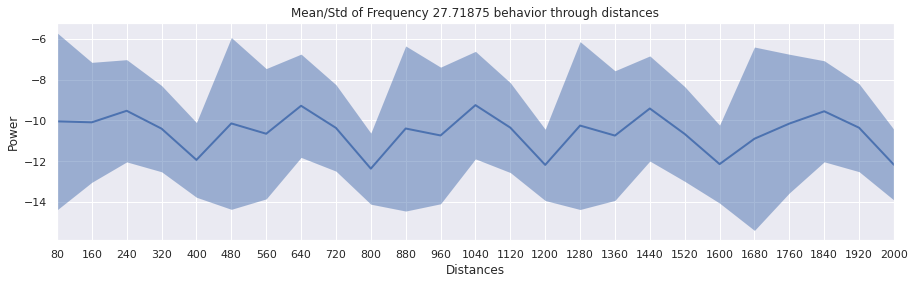

<Figure size 432x288 with 0 Axes>

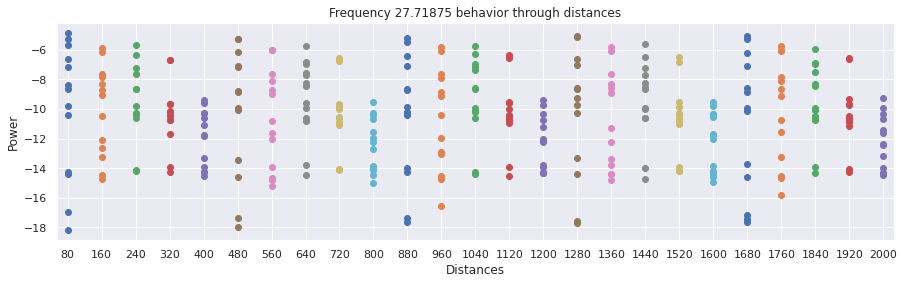

100%|██████████| 15/15 [00:15<00:00,  1.06s/it]

------------------


In [119]:
#cut_point = cur_off_idx(df_13_samples)
#working_df = select_working_data(df_13_samples, cut_point)

#point_to_eval = 1
#freq_behavior = calc_freq_behavior(working_df, selected_point=point_to_eval)

method = 'rand'
#for multiple evaluations at the same time
multi_freq_behavior = multiple_freq_analyzer(working_df, number_freq_to_analyze=15, method=method)

freq_mean_df, freq_std_df = freq_dict_to_df(multi_freq_behavior) # freq_mean_df, freq_std_df = freq_dict_to_df(multi_freq_behavior)
freq_mean_df.to_csv(path+'/Spectrum/freq_behavior/frequency_mean_'+str(method)+'.csv', index=False)
freq_std_df.to_csv(path+'/Spectrum/freq_behavior/frequency_std_'+str(method)+'.csv', index=False)

print('------------------')
for k in tqdm(multi_freq_behavior.keys()):
  individual_freq = {k:multi_freq_behavior[k]}
  plot_freq_mean_std(individual_freq, method, save=False)
  plot_freq_behavior(working_df, individual_freq, method, save=False)
  individual_freq = {}
  print('------------------')


# Gloabl Run

In [120]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [121]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Change the number to change the paths.
worker = workers[0]

if worker == "Ronald":
  path = "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

In [122]:
input_path = path + "/Spectrum/16QAM/25spans80km_withoutROADMs/dataSet_Spectrum31MHz_Samples_16QAM_75GHz_LongHaul_input_25x80km.xlsx"

In [123]:
# Pre-procesing 1(cleaning original file)
df = pd.read_excel(input_path, sheet_name = "Sheet1", skiprows=1)

#Dropping columns below sample_id 13 since the are empty
drop_rows = [drop_row for drop_row in range(325, df.shape[0])]
df_13_samples = df.drop(drop_rows)

# Adding missing PBRS_id (missing in original file)
snippet = []
val_cnt = 1
idx = 0
for sample in range(1, 14):
  for sample_id in range(0, 25):
    df_13_samples.at[idx, 'PBRS_id'] = val_cnt
    idx +=1
    snippet.append(val_cnt)
  val_cnt += 1
df_13_samples['PBRS_id'] = df_13_samples['PBRS_id'].astype(int)

# Fill nan values if found
df_13_samples.iloc[0].fillna(method='bfill', inplace=True)
df_13_samples.iloc[1:df_13_samples.shape[0]].fillna(method='pad', inplace=True)

In [124]:
# Pre-procesing 2 (Removing un wanted data(tails) and implement smoothining)

cut_point = cur_off_idx(df_13_samples)
working_df = select_working_data(df_13_samples, cut_point)

Calculating the cutoff values:


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


In [ ]:
# Procesing 1 (Calculating confusion matrix of pearson correlations)
s_id = 1

avg_p_matrix, avg_result_data = pearson_matrix(working_df , source_sample_id=s_id, eval_method = 'avg')
min_p_matrix, min_result_data = pearson_matrix(working_df , source_sample_id=s_id, eval_method = 'min')
max_p_matrix, max_result_data = pearson_matrix(working_df , source_sample_id=s_id, eval_method = 'max')


avg_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_AVG.csv'
avg_p_matrix.to_csv(avg_p_matrix_output_path, index=False)  

min_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MIN.csv'
min_p_matrix.to_csv(min_p_matrix_output_path, index=False)  

max_p_matrix_output_path = path + '/Spectrum/confusion_matrix_pearson/Correlation_Pearson_MAX.csv'
max_p_matrix.to_csv(max_p_matrix_output_path, index=False)

pickle_out(avg_result_data, 'avg_correlation_matrix')
pickle_out(min_result_data, 'min_correlation_matrix')
pickle_out(max_result_data, 'max_correlation_matrix')


Generating Pearson Confusion Matrix using (avg) method:


100%|██████████| 25/25 [00:17<00:00,  1.41it/s]


Generating Pearson Confusion Matrix using (min) method:


 32%|███▏      | 8/25 [00:05<00:12,  1.39it/s]

In [ ]:
# Procesing 2 (Evaluate behavior of specific frequency)
method = 'even'

#for multiple evaluations at the same time
multi_freq_behavior = multiple_freq_analyzer(working_df, number_freq_to_analyze=15, method=method)
pickle_out(multi_freq_behavior, 'multi_freq_behavior_results')

freq_mean_df, freq_std_df = freq_dict_to_df(multi_freq_behavior) # freq_mean_df, freq_std_df = freq_dict_to_df(multi_freq_behavior)
freq_mean_df.to_csv(path+'/Spectrum/freq_behavior/frequency_mean_'+str(method)+'.csv', index=False)
freq_std_df.to_csv(path+'/Spectrum/freq_behavior/frequency_std_'+str(method)+'.csv', index=False)

print('------------------')
for k in tqdm(multi_freq_behavior.keys()):
  individual_freq = {k:multi_freq_behavior[k]}
  plot_freq_mean_std(individual_freq, method, save=True)
  plot_freq_behavior(working_df, individual_freq, method, save=True)
  individual_freq = {}
  print('------------------')